# <center><u> Queueing Theory and Simulation Jupyter Notebook </u></center>
***

In [211]:
import numpy as np
import matplotlib.pyplot as plt

import math
from math import factorial

import random
from random import randint

## Section 1 - Indispensable Knowledge
### Motivation
Queues are everywhere, in a wild variety of forms. From physical queues in supermarkets, to more arbitrary queues like the number of freshly made hamburgers held in stock or items waiting to go in a furnace.

We want to find common grounds, do analysis and provide intuitions to optimize these systems.

There is a typical optimization problem. We want queues to clear and not to exceed a certain length, but in the process minimize the costs. There is a number of variables we might control, like how large the service system, how it is organised (think of one queue line or multiple) and the inflow of new jobs/customers. 

The difficulty lies in the stochastic nature of the system, often it is impossible to control the regularity of jobs coming in and/or time spend on each job. 

Sojourn time J is the typical time a job spends in the system.

We will analyse key performance measures like 

$p(n)$, the fraction of time the system contains $n$ customers.

$\pi(n)$, the fraction of customers that see a system with $n$ customers upon arrival

The mean, variance and distribution of waiting time $W$ <font color='green'>right?</font>

The average, variance and distribution of number of customers in the system <font color='green'>not sure yet</font> <b style='color:blue'> simply n? </b>
    
We will simplify to an enorenomous extend with mathematics. Then make it a bit more realistic with simulation. 

## Section 2 - Construction and simulation of queueing systems

### 2.1 Queueing systems in discrete time

***

$ a_k $ - number of jobs that arrive in period k

$ c_k $ - capacity during period k, i.e. number of jobs that can be served

$ d_k $ - number of departures in period k

$ L_k $ - number of jobs in the system at the end of period k, i.e. system length

Then we have the following basic queueing recursions:

$$ d_k = min\{L_{k-1}, c_k\} $$

$$ L_k = L_{k-1} + a_k - d_k $$

With this system we generate $\{L_i\}_{i=1}^\infty$ provided we have $L_0$. A sequence of numbers providing information about the dynamics of the *number of jobs in the system*

We can modify the recursion so that jobs can be served in the period they arrive with $ d_k = min\{L_{k-1} + a_k, c_k\} $

<font color='green'>Waiting time W and sojourn time J in discrete time? Notation the same for continuous version?</font>

Generally continuous, emperically it would depend on how one rounds the numbers, analytically on the distributions and assumptions made. I think in any case the notation is the same.

<font color='green'>Define service rate as a function of queue length, specify tolerance threshold (See 2.1.6) </font>

***

Defining functions for simple queueing recursions:

We define $\lambda$ to be the rate at which new jobs arrive in the system, and $\mu$ to be the rate at which jobs are served. Note that when either process is stochastic this definition still works; then they are incorparated (as parameters) in the distributions.

In [212]:
def data_valid(vector, periods):
    # Convert input data for arrivals and capacity to numpy array
    
    if isinstance(vector, np.ndarray):
        return(vector)
    
    elif isinstance(vector, list):
        convert = np.array(vector, dtype=float)
        return(convert)
    
    elif isinstance(vector, int):
    # Deterministic input for single value repeated for all periods
        convert = vector*np.ones(periods, dtype=float)
        return(convert)
    
    elif isinstance(vector, float):
        convert = vector*np.ones(periods)
        return(convert)

def discreteQ(num, a, c, L0, serve_now=False, K=np.inf, rej='end'):
    # serve_now=False assumes jobs that arrive in period k cannot be served in period k
    # K infinity assumes no blocking
    
    a = data_valid(a, num)
    c = data_valid(c, num)
    
    d = np.zeros_like(a, dtype=int)
    L = np.zeros_like(a, dtype=int)
    L[0] = L0
    
    loss = np.zeros_like(a)
    
    if serve_now == False:
        # Jobs that arrive in period k can be served in period k+1
        
        for k in range(1,num):
            d[k] = min(c[k], L[k-1])
            
        # Standard queueing system assumes no blocking threshold K unless stated otherwise
            if K == np.inf:
                L[k] = L[k-1] + a[k] - d[k]
            else:
                if rej == 'start':
                    loss[k] = max(L[k-1] + a[k] - K, 0)
                    L[k] = L[k-1] + a[k] - d[k] - loss[k]
                elif rej == 'end':
                    loss[k] = max(L[k-1] + a[k] - d[k] - K, 0)
                    L[k] = L[k-1] + a[k] - d[k] - loss[k]
            
    elif serve_now == True:
        # Jobs that arrive in period k can be served in period k
        
        for k in range(1,num):
            d[k] = min(c[k], L[k-1] + a[k])
            
            if K == np.inf:
                L[k] = L[k-1] + a[k] - d[k] 
            else:
                if rej == 'start':
                    loss[k] = max(L[k-1] + a[k] - K, 0)
                    L[k] = L[k-1] + a[k] - d[k] - loss[k]
                elif rej == 'end':
                    loss[k] = max(L[k-1] + a[k] - d[k] - K, 0)
                    L[k] = L[k-1] + a[k] - d[k] - loss[k]
        
    return(L, a, d, c, loss)


def output_data(discreteQsim, var):
    data = []
    for i in var:
        if i == 'L': 
            data.append(discreteQsim[0])
        if i == 'a':
            data.append(discreteQsim[1])
        if i == 'd':
            data.append(discreteQsim[2])
        if i == 'c':
            data.append(discreteQsim[3])
        if i == 'loss':
            data.append(discreteQsim[4])
    if len(var) == 1:
        data = np.array(data[0])
        #data = data[0]
        
    return(data)

***

**Exercise 2.1.1** - Discrete queue basic recursions

In [213]:
num = 4
a = [0,5,4,9]
c = 7
L0 = 8

sim = discreteQ(num,a,c,L0)
output = output_data(sim, ['L', 'd'])

print(output)

[array([8, 6, 4, 9]), array([0, 7, 6, 4])]


***
**Exercise 2.1.3** - Blocking

In [214]:
num = 4
a = [0,10,3,6]
c = [0,5,5,5]
K=8

sim = discreteQ(num,a,c,L0=0,K=8)
L = output_data(sim, 'L')
d = output_data(sim, 'd')
l = output_data(sim, ['loss'])

#Now it can print in order but loss has to be in a list? I don't understand why... is 'k' not a string?
print(L, d, l)

report = output_data(sim, ['L', 'd', 'loss'])
print(report)

output_data(sim, 'loss')

[0 8 6 7] [0 0 5 5] [0. 2. 0. 0.]
[array([0, 8, 6, 7]), array([0, 0, 5, 5]), array([0., 2., 0., 0.])]


[]

In [215]:
type('loss')
for i in 'loss':
    print(i)
#aha

l
o
s
s


In [216]:
frac_lost = sum(l)/sum(a)
frac_lost

0.10526315789473684

**With randomness**

Double randomness even. 
For same period serve $K$ is is the limit of $L$ for no same period serve about half?

seems to be about halved when newcomers aren't served in the same period.

I'll do the math later, but there seems to be a difference of $d \mathbb{i}(\textrm{loss}>0}$

Adding a lot of comparisons

Lost fraction of customers:
0.04371584699453552 

Percentage of average reduction in queuelenght
0.3729456384323641 



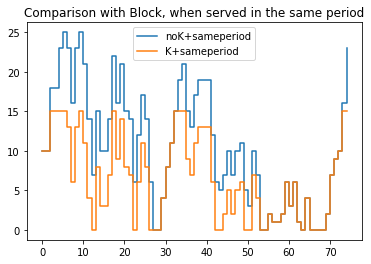

In [217]:
np.random.seed(1210)
num = 75
a = np.random.randint(0,15, num)  
c = np.random.randint(6,10, num)
simK = discreteQ(num,a,c,L0=10,K=15, serve_now=True)
sim = discreteQ(num,a,c,L0=10, serve_now=True)
simn = discreteQ(num,a,c,L0=10,serve_now=False)
simnK = discreteQ(num,a,c,L0=10,K=15, serve_now=False)

plt.plot(sim[0],ds='steps-post', label='noK+sameperiod')
plt.plot(simK[0],ds='steps-post', label='K+sameperiod')
plt.legend()
plt.title('Comparison with Block, when served in the same period')
print('Lost fraction of customers:')
print(sum(simK[4])/sum(a),"\n")
print('Percentage of average reduction in queuelenght')
print((sum(sim[0]) - sum(simK[0]))/sum(sim[0]),"\n")

Lost fraction of customers:
0.08925318761384335 

percentage of absolute reduction Queue Length
0.3203194321206744 



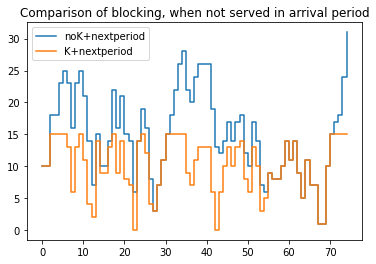

In [218]:
plt.plot(simn[0],ds='steps-post', label='noK+nextperiod')
plt.plot(simnK[0],ds='steps-post', label='K+nextperiod')
plt.legend()
plt.title('Comparison of blocking, when not served in arrival period')
print('Lost fraction of customers:')
print(sum(simnK[4])/sum(a),"\n")

print('percentage of absolute reduction Queue Length')
print((sum(simn[0]) - sum(simnK[0]))/sum(simn[0]),"\n")

difference queue Lenght per period:
3.6 

probability having more, less or the same loss when serving in same period: 

0.0 

0.09333333333333334 

0.9066666666666666 



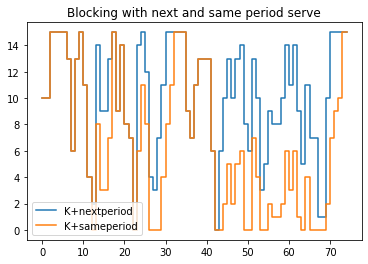

In [219]:
plt.plot(simnK[0],ds='steps-post', label='K+nextperiod')
plt.plot(simK[0],ds='steps-post', label='K+sameperiod')
plt.legend()
plt.title('Blocking with next and same period serve')

print("difference queue Lenght per period:")
print(np.mean(simnK[0] - simK[0]), "\n")

print("probability having more, less or the same loss when serving in same period: \n")
print(np.mean(simnK[4] < simK[4]), "\n")
print(np.mean(simnK[4] > simK[4]), "\n")
print(np.mean(simnK[4] == simK[4]), "\n")

We may ask ourselfs whether the above is really a valid comparison,
this is something we can in most cases not control. 

***

**Long term effects of not blocking**
Setting a new seed and looking at the long term effects:

mean queue length no blocking: 10.75 

mean queue length blocking:    5.863 

average number of people skipped per period: 0.257 

share of loss: 0.0367


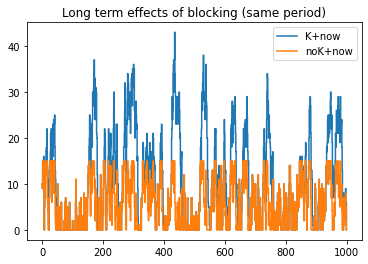

In [220]:
np.random.seed(130)

num = 1000
a = np.random.randint(0,15, num)  
c = np.random.randint(6,10, num)
simK = discreteQ(num,a,c,L0=10,K=15, serve_now=True)
sim = discreteQ(num,a,c,L0=10, serve_now=True)
simn = discreteQ(num,a,c,L0=10,serve_now=False)
simnK = discreteQ(num,a,c,L0=10,K=15, serve_now=False)

plt.plot(sim[0],ds='steps-post', label='K+now')
plt.plot(simK[0],ds='steps-post', label='noK+now')
plt.legend()
plt.title('Long term effects of blocking (same period)')

print('mean queue length no blocking:', end=' ')
print(np.mean(sim[0]), "\n")
print('mean queue length blocking:   ', end=' ')
print(np.mean(simK[0]),"\n")

print('average number of people skipped per period: ', end='')
print(np.mean(simK[4]), "\n")
print('share of loss: ',  end='')
print(round(sum(simK[4])/sum(a), 4))

**wow that can get way out of bounds!**
We lose only about 4% of the potential customes, but reduce the average queueing length by about 45%. When blocking the length won't surpass $K = 15$, obviously, however the maximum over a 1000 periods is far above 40! That can also lead to angry customers and overstressed employees.

***

**Exercise 2.1.6** - Cost Models

In [221]:
# Define queueing system
num = 5

a = [0,4,8,2,1]
c = [3,3,3,3,3]

L = [0]*len(a)
L[0] = 6
d = [0]*len(a)

p_cost = np.zeros(num)
h_cost = np.zeros(num)

p = 2 # service capacity cost parameter
h = 1 # holding cost

In [222]:
for i in range(1,len(a)):
    d[i] = min(L[i-1]+a[i], c[i])
    L[i] = L[i-1] + a[i] - d[i]
    p_cost[i] = p*c[i]
    h_cost[i] = h*L[i]
    
tot_cost = sum(p_cost) + sum(h_cost)
tot_cost, h_cost, p_cost

(63.0, array([ 0.,  7., 12., 11.,  9.]), array([0., 6., 6., 6., 6.]))

***
**Exercise 2.1.7** - Threshold control policy

* Server works at rate $c$ if number of jobs exceed $N$, otherwise is not used
* Policy ensures that server capacity is fully used or not at all

In [223]:
# Define queueing system
np.random.seed(10)
num = 20

N = 20 # server works if there are N jobs, otherwise is not used

a = 10*np.ones(num)
c = 12*np.ones(num)

L = np.zeros_like(a)
d = np.zeros_like(a)

L[0] = 0

for i in range(1,len(a)):
    if (L[i-1] < N):
        L[i] = L[i-1] + a[i] # d[i] remains zero
    else:
        d[i] = min(L[i-1], c[i])
        L[i] = L[i-1] + a[i] - d[i]

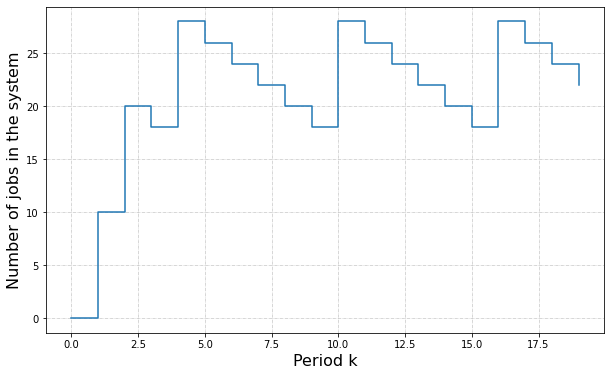

In [224]:
fig, ax = plt.subplots(figsize = (10,6))
fig.set_facecolor('white')
ax.set_facecolor('white')
ax.grid(lw=0.5, ls='-.', zorder = 1)
ax.set_xlabel('Period k', fontsize = 16, fontfamily='Candara')
ax.set_ylabel('Number of jobs in the system', fontsize = 16, fontfamily='Candara')
plt.plot(L, ds='steps-post')

***
**Exercise 2.1.8** - N-Policy cost model

* Machine switches on when system length hits $N$
* Machine switches off when system becomes empty (typically rarely hits exactly zero, so min threshold $M$ may be better)
* Cost $K$ to switch on machine
* Cost $\beta$ per period when machine is on
* Cost $h$ per job per period in the system

In [225]:
np.random.seed(5)
num = 100
a = np.random.randint(0,12,num)
c = np.random.randint(0,16,num)
L = np.zeros(num)
d = np.zeros(num)

L[0] = 10
N = 20

I = np.zeros(num)

for k in range(1,len(a)):
    # Turn off when system is empty
    if (L[k-1] == 0):
        d[k] = 0
        I[k] = 0
    # Turn on when system reaches threshold N
    elif (L[k-1] >= N):
        d[k] = min(L[k-1], c[k])
        I[k] = 1
    # Remain on/off until threshold is met
    elif (L[k-1] < N):
        if (I[k-1] == 0):
            d[k] = 0
            I[k] = 0
        else:
            d[k] = min(L[k-1], c[k])
            I[k] = 1
        
    L[k] = L[k-1] + a[k] - d[k]

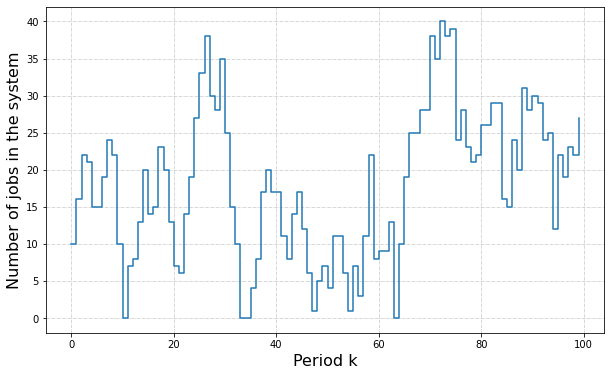

In [226]:
fig, ax = plt.subplots(figsize = (10,6))
fig.set_facecolor('white')
ax.set_facecolor('white')
ax.grid(lw=0.5, ls='-.', zorder = 1)
ax.set_xlabel('Period k', fontsize = 16, fontfamily='Candara')
ax.set_ylabel('Number of jobs in the system', fontsize = 16, fontfamily='Candara')
plt.plot(L, ds='steps-post')

Implementing associated costs:

In [227]:
beta = 1
h = 2
K = 10

on = 0 # number of times the machine is switched on

for j in range(1,len(I)):
    if I[j] > I[j-1]:
        on += 1
    else:
        pass
    
tot_cost = beta*sum(I) + h*sum(L) + K*on
tot_cost, on

(3711.0, 4)